# Imports

In [123]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 12
import seaborn as sns
%matplotlib inline

In [124]:
from pf_module.pf import ParticleFilter
from gbm_module.gbm import GeometricBrownianMotion

# Demo of each module

## Geometric Brownian motion
The geometric Brownian motion class handles geometric Brownian motions satisfying
$$
dX_t = \alpha X_t dt + \sigma^2 X_t dW_t
$$
where $W_t$ denotes a Wiener process. The (Ito) integration of this SDE gives
$$
X(t) = X(0)\exp\left( \sigma W(t) + \left(\alpha - \frac{1}{2}\sigma^2\right)t \right)
$$

In [125]:
# Instantiation
x0,trange = 1,np.linspace(0,1000,1001)
alpha,sigma = 1e-3,1e-2
gBM = GeometricBrownianMotion(
    alpha=alpha,
    sig=sigma,
    iv=x0,
    trange=trange
)

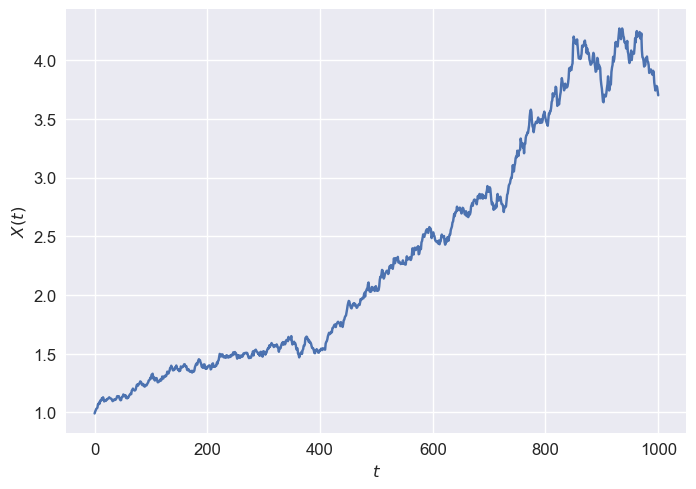

In [128]:
# Single simulation
path1 = gBM.integrate()
plt.plot(gBM.trange,path1)
plt.xlabel('$t$')
plt.ylabel('$X(t)$')
plt.show()

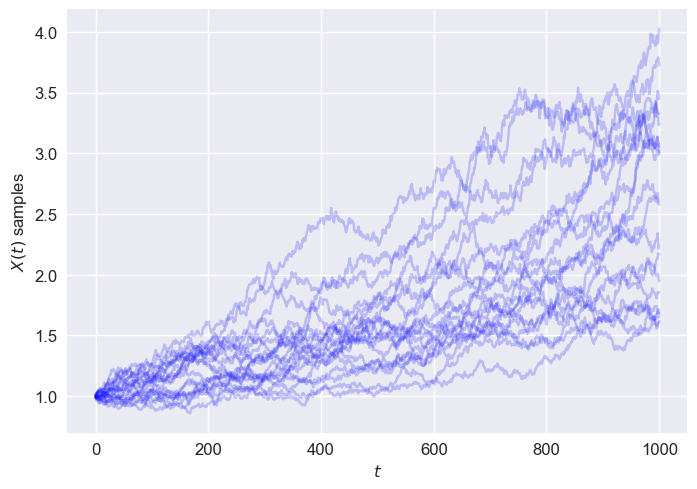

In [129]:
# Ensemble simulation
Nmc = 20 # number of monte carlo sims in the ensemble
ensemble_paths = gBM.ensemble(Nmc)
plt.plot(gBM.trange,ensemble_paths,
         color='b',alpha=0.2)
plt.xlabel('$t$')
plt.ylabel('$X(t)$ samples')
plt.show()

## Particle filter module
The particle filter is a recursive Bayesian state estimator. Given some initial distribution of states 
$\theta_k$, $k=1,...,m$, the particle filter evaluates a model $g(t;\theta_k)$ and computes a likelihood
of observation $\mathcal{L}(g(t;\theta_k)|z_k)$ relative to some data. The $k$th particle $\bf{p}_k$ is then weighted with this likelihood,
and at each iteration as new data is assimilated, the particle ensemble is resampled according to these weights.
Finally, the particles / state vectors $\theta_k$ are perturbed with some prescribed noise $\varepsilon\sim N(\bf{0},\Sigma)$ in the state space
to represent uncertainty in the evolution of the state space.

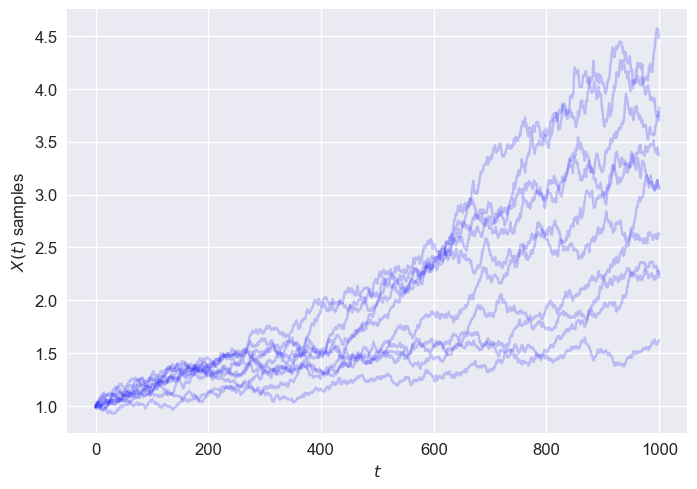

In [132]:
pf = ParticleFilter(gBM)
evals = pf.evaluate_args([1,trange],
                            [alpha,sigma],
                            Nevals=10)
plt.plot(pf.gbm.trange,evals,c='b',alpha=0.2)
plt.xlabel('$t$')
plt.ylabel('$X(t)$ samples')
plt.show()

The parameters of the geometric Brownian motion can be manipulated directly through the ParticleFilter object, and in fact will be when the filtration is executed. 

# Example filtration
This version of the particle filter was implemented with a _lookback window_. Traditionally, each point would be treated as an update for the state space vector $\theta = [\alpha,\sigma]$ to dynamically change the local behavior of the model / process $X(t;\theta)$. However, we can generalize this by including sequential information to encode temporal correlation structure. For example, in real world assets, the price $S_t$ may not just depend on the previous price $S_{t-1}$. Capturing this longer term correlation in the Bayesian calibration of a stochastic model was the goal of this model.

First, we'll do a static calibration (i.e. $\alpha$ and $\sigma$ are not changing.)

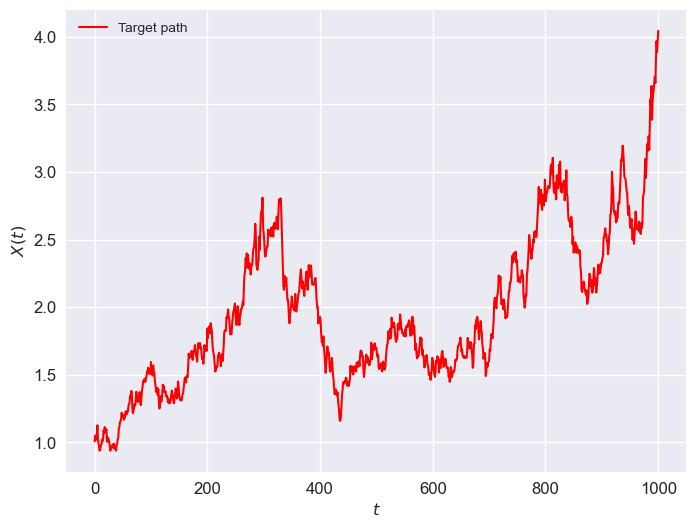

In [330]:
np.random.seed(314159) # setting for reproducibility
targ_alpha=0.002; targ_sigma=0.03
iv = 1; trange = np.linspace(0,1000,1001)
gBM_target = GeometricBrownianMotion(alpha=targ_alpha,sig=targ_sigma,
                                     iv=iv,trange=trange)
sample_path = gBM_target.integrate()
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(gBM_target.trange,sample_path,
         color='r',lw=1.5,
         label='Target path')
ax.set_xlabel('$t$')
ax.set_ylabel('$X(t)$')
ax.legend()
plt.show()

The ParticleFilter class accepts arguments to initialize the random state space vectors. The default option is to initialize each component of the $k$th particle $\theta_k$ _independently_ from its own uniform distribution. We have no _a priori_ information w.r.t. the joint density function of the vector $\theta_k$, so we make the independence assumption for simplicity. Each component (in our case, each $\alpha_k,\sigma_k$) is drawn from $U[(\cdot)_l,(\cdot)_u]$, where the lower and upper bounds are user specified. The number of particles is user-specified as well.

In [337]:
# instantiating a clean gBM object with unknown dynamic arguments but known initial value
# and time domain.
gBM_generic = GeometricBrownianMotion(alpha=0,sig=0,iv=1,trange=gBM_target.trange)
pf_ex = ParticleFilter(gBM_generic)
# setting the bounds for particle generation; in practice, some heuristic would be used to bound the 
# likely values (e.g. doing some example simulations and comparing ensembles qualitatively.)
bounds = np.array([[0.001,0.007],[0.01,0.08]])
example_particles = pf_ex.generate_particles(100,bounds)

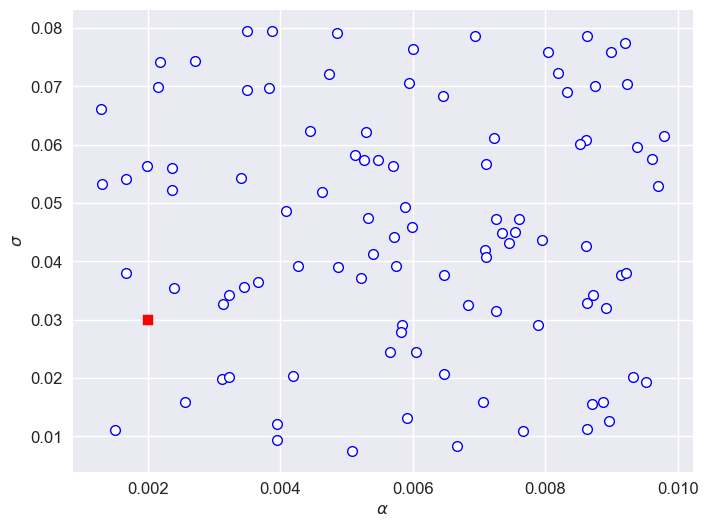

In [338]:
# visualizing the state space
fig,ax = plt.subplots(figsize=(8,6))
ax.scatter(example_particles[:,0],example_particles[:,1],
           edgecolor='b',facecolor='w',lw=1,
           label='Initialized particles')
ax.scatter(targ_alpha,targ_sigma,marker='s',c='r',
           label='Target state')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\sigma$')
plt.show()

Each one of these particles corresponds to a set of parameters to evaluate the geometric Brownian motion. Note that they will be reweighted by likelihood and perturbed. We compute the likelihood of each particle along its time domain via an ensemble. We recognize that the Fokker-Planck solution provides a potentially better avenue for the likelihood estimation by providing a functional form for the probability density of the particle's position given time, but numerically solving this system for each particle and at each timestep becomes computationally prohibitive (in the scope of this project). We therefore use a Monte Carlo approach to simulate paths and compute the likelihood of the particle based on an ensemble estimate.
Consider the $k$th particle of the generated ensemble, where $k=50$ (as an example).

Example particle paramters:
drift : 0.00151
volatility : 0.01104


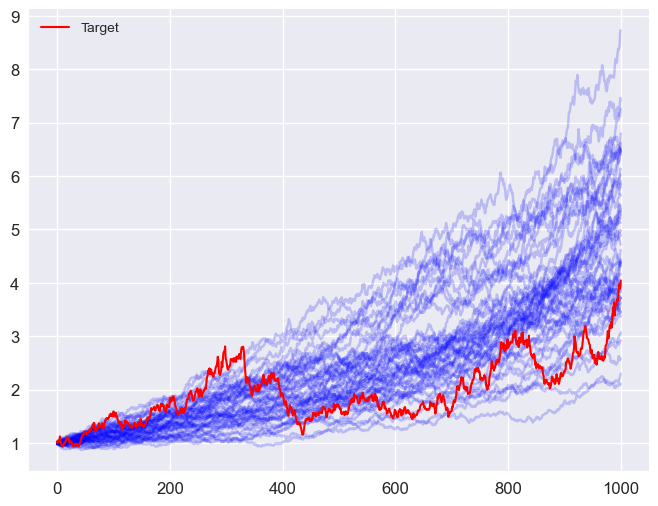

In [339]:
k = 50
Nevals = 50
print('Example particle paramters:')
print(f'drift : {example_particles[k][0]:.5f}')
print(f'volatility : {example_particles[k][1]:.5f}')
eval_k = pf_ex.evaluate_args([pf_ex.gbm.iv,pf_ex.gbm.trange],
                             example_particles[k],
                             Nevals=Nevals)
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(pf_ex.gbm.trange,eval_k,
        color='b',alpha=0.2)
ax.plot(gBM_target.trange,sample_path,
        color='r',lw=1.5,
        label='Target')
ax.legend()
plt.show()

We'll show the evolution of the lognormal PDF over time to visualize the likelihood of the particle. Traditionally this would probably be achieved by solving the Fokker-Planck PDE.

In [340]:
from scipy.stats import lognorm
colormap = plt.get_cmap ("cool") # for visualization

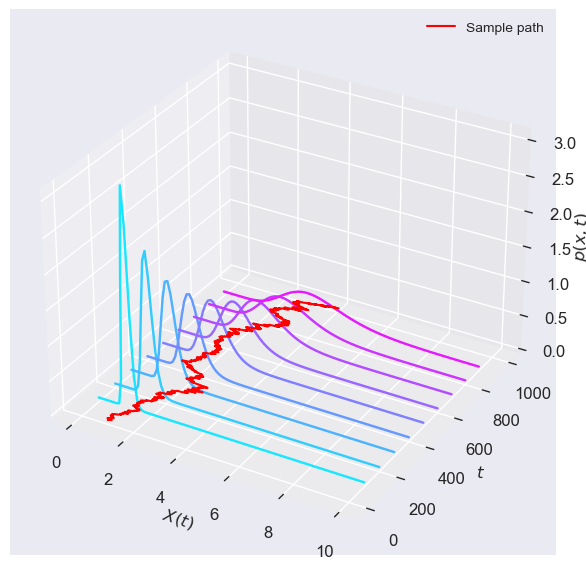

In [342]:
Nens = 500 # large number of evaluations for 
eval_k = pf_ex.evaluate_args([pf_ex.gbm.iv,pf_ex.gbm.trange],
                             example_particles[k],
                             Nevals=Nens)
example_ts = np.arange(100,1000,100)
color_ts = colormap(example_ts/pf_ex.gbm.trange[-1]) # scaling the colors
lognorm_params = [lognorm.fit(eval_k[t,:]) for t in example_ts]
local_likelihoods = [lognorm.pdf(sample_path[t],*lognorm_params[i]) for i,t in enumerate(example_ts)]
pos_range = np.linspace(0,10,100)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
for t,params,c in zip(example_ts,lognorm_params,color_ts):
    ax.plot(xs=pos_range,
            ys=np.ones_like(pos_range)*t,
            zs=lognorm.pdf(pos_range,*params),
            color=c)
ax.plot(xs=sample_path,ys=gBM_target.trange,zs=np.zeros_like(sample_path),
        color='r',lw=1.5,label='Sample path')
ax.legend()
ax.set_xlabel('$X(t)$')
ax.set_ylabel('$t$')
ax.set_zlabel('$p(x,t)$')
plt.tight_layout()
plt.show()

To calculate the particle likelihood, we now compute the average likelihood along the time domain at each point. Let the points at which the likelihood is calculated be $\Pi = [t_0,...,t_N]$ with some maximum spacing given by $h$. We want to compute $\mathcal{L}(\theta_k;X(t))$, which is the likelihood of parameters $\theta_k$ given an observed path $X(t)$. We assert that 
$$
\lim_{h\rightarrow 0} \sum_{i=0}^Nh\mathcal{L}_i(\theta_k;X(t_i)) = \int_{0}^T p(X(t),t)dt
$$
where $p(x,t)$ satisfies the Fokker-Planck equation corresponding to geometric Brownian motion. This is simply the limit of a Riemann integral approximation. We can visualize the (discrete) integral by plotting the discrete mapping $f:\Pi\rightarrow\mathcal{L}(\theta;X(\Pi))$.

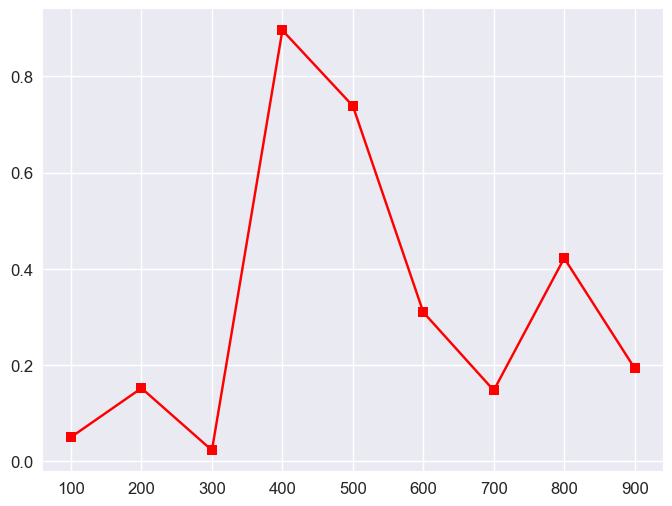

In [349]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(example_ts,local_likelihoods,
        marker='s',
        color='r')
plt.show()

Using this metric, we can now update each particle with its likelihood relative to the sample path.

In [351]:
lognorm.pdf(gBM_target.iv,lognorm.fit(eval_k[0,:]))

array([9.11393184e+03,            nan, 1.55812619e-03])